In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('merged_dataset.csv')

In [ ]:
df.head()

,user,age,status,gender,drinks,height,smokes,religion,genre,music_decade,music_vibe,listening_frequency,concert
0,user0,31,single,female,yes,168.0,no,hinduism,K-Pop,2020s,Relaxing and Chill,Frequently,"No, I prefer not to attend concerts"
1,user1,50,single,female,yes,175.0,no,buddhism,K-Pop,2020s,Upbeat and Energetic,Frequently,"Sometimes, depending on the artist or event"
2,user2,25,single,male,yes,188.0,no,confucianism,Traditional & Folk Music,2000s,Relaxing and Chill,Frequently,"No, I prefer not to attend concerts"
3,user3,39,single,male,yes,175.0,no,hinduism,Pop,2010s,Relaxing and Chill,Frequently,"No, I prefer not to attend concerts"
4,user4,22,single,male,yes,170.0,yes,buddhism,Indie/Alternative,1980s,Upbeat and Energetic,Frequently,"Sometimes, depending on the artist or event"


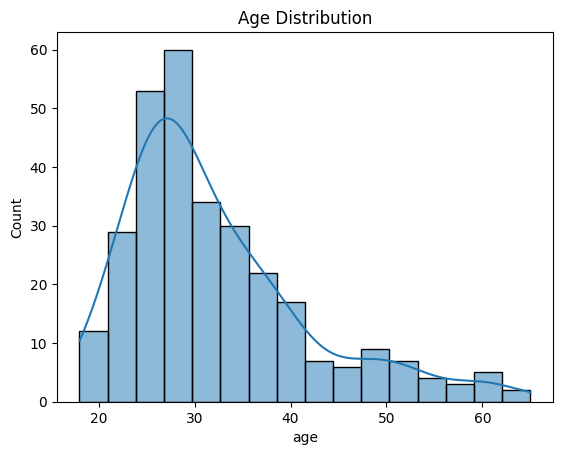

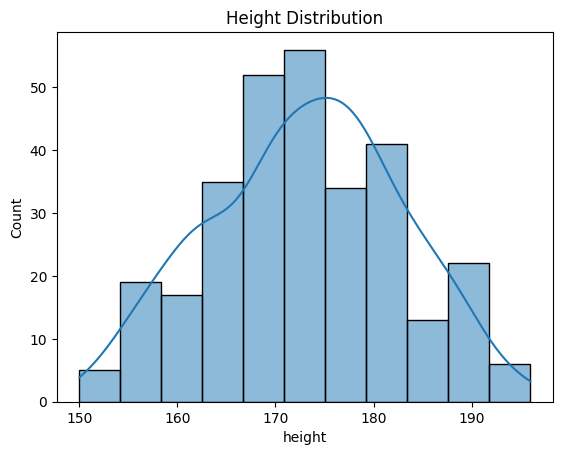

In [ ]:
# Histogram to see data distribution of 'age' and 'height'

sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['height'], kde=True)
plt.title('Height Distribution')
plt.show()


In [ ]:
print(df['drinks'].unique())

['yes' 'no']


In [ ]:
def map_smokes_drinks(df):
    return df.assign(
        smokes=df['smokes'].map({'yes': 1, 'no': 0}),
        drinks=df['drinks'].map({'yes': 1, 'no': 0})
    )

def lowercase_columns(df):
    return df.assign(
        religion=df['religion'].str.lower(),
        genre=df['genre'].str.lower(),
        music_vibe=df['music_vibe'].str.lower()
    )

def replace_concert(df):
    return df.assign(
        concert=df['concert'].replace({
            'No, I prefer not to attend concerts': 'no',
            'Sometimes, depending on the artist or event': 'sometimes',
            'Yes, I love attending concerts': 'yes'
        })
    )


In [ ]:
# Define the columns for categorical and numerical features
cat_columns = ['religion', 'genre', 'music_vibe', 'music_decade', 'listening_frequency', 'concert']
num_columns = ['age', 'height']

# Define the preprocessing pipeline for categorical and numerical columns
preprocess_pipeline = Pipeline(steps=[
    ('smokes_drinks', FunctionTransformer(map_smokes_drinks, validate=False)),
    ('lowercase', FunctionTransformer(lowercase_columns, validate=False)),
    ('concert', FunctionTransformer(replace_concert, validate=False)),
    # OHE and Scaling
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop=None), cat_columns),
            ('num_age', MinMaxScaler(), ['age']),
            ('num_height', StandardScaler(), ['height']),
            ('smokes_drinks', 'passthrough', ['smokes', 'drinks']),
        ]
    )),
])

# Fit and transform the data using the preprocessing pipeline
df_processed = preprocess_pipeline.fit_transform(df[cat_columns + num_columns + ['smokes', 'drinks']])

# Convert the sparse matrix to a dense matrix (if needed)
df_processed = df_processed.toarray() if isinstance(df_processed, scipy.sparse.csr.csr_matrix) else df_processed

# Get the column names for the transformed categorical features
encoded_columns = list(preprocess_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(cat_columns))

# Include the processed 'smokes' and 'drinks' columns
processed_columns = encoded_columns + ['age_scaled', 'height_scaled', 'smokes', 'drinks']

# Create DataFrame for the processed data
df_processed = pd.DataFrame(df_processed, columns=processed_columns)

# Add the 'user' and 'gender' columns back to the processed DataFrame
df_processed['user'] = df['user']
df_processed['gender'] = df['gender']

<ipython-input-5-7c1f22a18b1b>:25: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  df_processed = df_processed.toarray() if isinstance(df_processed, scipy.sparse.csr.csr_matrix) else df_processed


In [ ]:
df_processed.iloc[0].values

array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.276595744680851,
       -0.5271374820458772, 0.0, 1.0, 'user0', 'female'], dtype=object)

In [ ]:
df_processed.columns

Index(['religion_buddhism', 'religion_confucianism', 'religion_hinduism',
       'religion_islam', 'religion_protestant christianity',
       'religion_roman catholicism', 'genre_ballad', 'genre_blues',
       'genre_classical', 'genre_country', 'genre_dangdut', 'genre_edm',
       'genre_edm (electronic dance music)', 'genre_hip-hop/rap',
       'genre_indie/alternative', 'genre_j-pop', 'genre_jazz', 'genre_k-pop',
       'genre_metal', 'genre_pop', 'genre_pop indonesia', 'genre_punk',
       'genre_r&b', 'genre_reggae', 'genre_rock', 'genre_soul',
       'genre_traditional & folk music', 'music_vibe_dark and intense',
       'music_vibe_emotional and deep', 'music_vibe_relaxing and chill',
       'music_vibe_romantic and smooth', 'music_vibe_upbeat and energetic',
       'music_decade_1970s', 'music_decade_1980s', 'music_decade_1990s',
       'music_decade_2000s', 'music_decade_2010s', 'music_decade_2020s',
       'listening_frequency_Frequently', 'listening_frequency_Never',
       

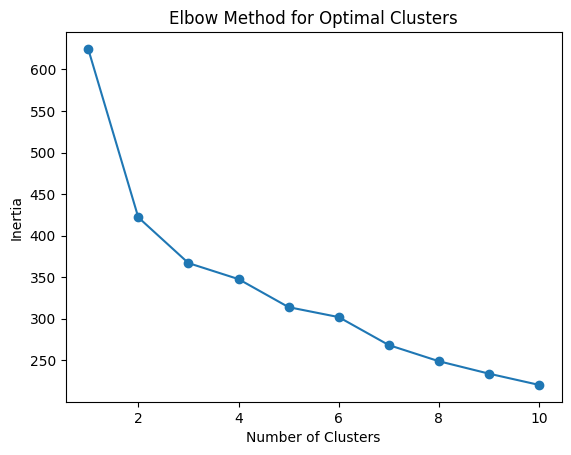

In [ ]:
# Elbow Method to find the optimal number of clusters
general_pref = [
    'religion_buddhism', 'religion_confucianism', 'religion_hinduism', 'religion_islam', 'religion_protestant christianity',
    'religion_roman catholicism', 'age_scaled', 'height_scaled',
    'smokes', 'drinks'
]

general_df = df_processed[general_pref]

inertia = []
for i in range(1, 11):  # Test with 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(general_df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
cluster_columns = [
    'religion_buddhism', 'religion_confucianism', 'religion_hinduism', 'religion_islam',
    'religion_protestant christianity', 'religion_roman catholicism', 'age_scaled', 'height_scaled',
    'smokes', 'drinks'
]

# Extract the data for clustering
X = df_processed[cluster_columns]

# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get the cluster labels
df_processed['cluster'] = kmeans.labels_

In [ ]:
music_pref_columns = [
    'genre_ballad', 'genre_blues', 'genre_classical', 'genre_country', 'genre_dangdut',
    'genre_edm', 'genre_edm (electronic dance music)', 'genre_hip-hop/rap', 'genre_indie/alternative',
    'genre_j-pop', 'genre_jazz', 'genre_k-pop', 'genre_metal', 'genre_pop', 'genre_pop indonesia',
    'genre_punk', 'genre_r&b', 'genre_reggae', 'genre_rock', 'genre_soul', 'genre_traditional & folk music',

    'music_vibe_dark and intense', 'music_vibe_emotional and deep', 'music_vibe_relaxing and chill',
    'music_vibe_romantic and smooth', 'music_vibe_upbeat and energetic',

    'music_decade_1970s', 'music_decade_1980s', 'music_decade_1990s', 'music_decade_2000s',
    'music_decade_2010s', 'music_decade_2020s',

    'listening_frequency_Frequently', 'listening_frequency_Never', 'listening_frequency_Occasionally',
    'listening_frequency_Only in specific situations', 'listening_frequency_Rarely',

    'concert_no', 'concert_sometimes', 'concert_yes'
]

# Extract the music preference columns from df_processed
music_pref_df = df_processed[music_pref_columns]

# Create a cosine similarity matrix for all users
cos_sim_matrix = cosine_similarity(music_pref_df)

# Loop over each cluster and find matches
df_processed['cosine_similarities'] = None

for cluster_id in df_processed['cluster'].unique():
    # Get the indices of users in the current cluster
    cluster_indices = df_processed[df_processed['cluster'] == cluster_id].index

    # Calculate cosine similarity for users in the current cluster
    cluster_cos_sim_matrix = cos_sim_matrix[cluster_indices][:, cluster_indices]

    # Get the indices of the most similar users (excluding the user itself)
    for idx in cluster_indices:
        # Find the relative index of the current user in the cluster
        rel_idx = np.where(cluster_indices == idx)[0][0]

        # Get similarity row for the user
        user_similarities = cluster_cos_sim_matrix[rel_idx]

        # Get the indices of the most similar users, excluding the user itself
        similar_users_idx = np.argsort(user_similarities)[::-1][1:31]

        # Map back to the original user indices and store them
        similar_users = cluster_indices[similar_users_idx]
        df_processed.at[idx, 'cosine_similarities'] = list(similar_users)

In [ ]:
def preprocess_user(user_id, df, preprocess_pipeline):
    # Extract the user's data from the original dataframe
    user_data = df[df['user'] == user_id]

    # Preprocess the user's data using the preprocessing pipeline
    user_data_processed = preprocess_pipeline.transform(user_data[cat_columns + num_columns + ['smokes', 'drinks']])

    # Only keep the necessary features for clustering (the ones used for KMeans)
    user_data_processed = user_data_processed[:, :len(cluster_columns)]

    return user_data_processed

def assign_cluster(user_data_processed, df_processed, kmeans):
    # Predict the cluster label for the processed user data
    cluster_label = kmeans.predict(user_data_processed)[0]
    return cluster_label

def find_similar_users(user_id, df_processed, cos_sim_matrix):
    # Get the index of the current user
    user_idx = df_processed[df_processed['user'] == user_id].index[0]

    # Get the similarity row for the current user from the cosine similarity matrix
    user_similarities = cos_sim_matrix[user_idx]

    # Get the indices of the most similar users (excluding the user itself)
    similar_users_idx = np.argsort(user_similarities)[::-1][1:31]

    # Get the user IDs of the most similar users
    similar_users = df_processed.iloc[similar_users_idx]

    # Get the gender of the current user
    current_user_gender = df_processed.iloc[user_idx]['gender']

    # Filter out users of the same gender
    opposite_gender_users = similar_users[similar_users['gender'] != current_user_gender]

    return opposite_gender_users['user'].values

def match_users(user_id, df, preprocess_pipeline, kmeans, cos_sim_matrix):
    # Step 1: Preprocess the input user data
    user_data_processed = preprocess_user(user_id, df, preprocess_pipeline)

    # Step 2: Assign the user to a cluster
    cluster_label = assign_cluster(user_data_processed, df_processed, kmeans)

    # Step 3: Get the list of similar users from the same cluster
    similar_users = find_similar_users(user_id, df_processed, cos_sim_matrix)

    return similar_users

In [ ]:
user_id = 'user0'
similar_users = match_users(user_id, df, preprocess_pipeline, kmeans, cos_sim_matrix)

print(f"Users similar to {user_id}: {similar_users}")

Users similar to user0: ['user69' 'user16' 'user37' 'user205' 'user182' 'user179' 'user22'
 'user184' 'user3' 'user11' 'user2' 'user154' 'user6' 'user215' 'user78'
 'user212' 'user64']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [ ]:
df.iloc[205].values

array(['user205', 35, 'in a relationship', 'male', 'yes', 193.0, 'no',
       'hinduism', 'hip-hop/rap', '2010s', 'Relaxing and Chill',
       'Frequently', 'No, I prefer not to attend concerts'], dtype=object)

In [ ]:
import joblib

# Create a dictionary containing all necessary components
model_data = {
    'preprocess_pipeline': preprocess_pipeline,
    'kmeans': kmeans,
    'cos_sim_matrix': cos_sim_matrix,
}

# Save the dictionary to a file using joblib
joblib.dump(model_data, 'recommender_model.pkl')

['recommender_model.pkl']

user
age
status
gender
drinks
height
smokes
religion
genre
music_decade
music_vibe
listening_frequency
concert